Topic modeling approach 2:
W2V --> Kmeans 

For each new recipe query, this method finds the most similar recipe  in Training data (hit) and outputs: 
*   Hit's image id (image prediction)
*   Hit's recipe title (recipe prediction)
*   All other info related to Hit can be found based on image id.





Some prep

In [1]:
# Remove these modules as needed. I just copied this cell from another notebook
from google.colab import drive
drive.mount('/content/gdrive')
import os, csv
import json  
import pandas as pd
import numpy as np
import re
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from operator import itemgetter
import operator
import pickle
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader 
import time
import copy
import torch.nn.functional as F

Mounted at /content/gdrive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#os.chdir("/content/gdrive/My Drive/2021 Summer CS7643 Share Folder/data/recipe1M")
os.chdir("/content/gdrive/My Drive/Deep learning project/recipe1M_layers")


In [ ]:
#I directly imported the saved csv files from previous step
df_title_val = pd.read_csv("layer1_title_val.csv")

In [ ]:
# some cleaning (same as before, nothing changed) 
stop_words = stopwords.words('english')
#may need to add more stop words such as recipe
stop_words.extend(['from', 'with', 'and', 'recipe', 'in', 'a', 's'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word.strip() for word in simple_preprocess(str(doc)) 
             if word.strip() not in stop_words] for doc in texts]
data = df_title_val["title_clean"].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)

In [ ]:
#df_title_test.to_csv("layer1_title_test.csv")
df_title_test = pd.read_csv("layer1_title_test.csv")
# Generate the LDA model based on 20% of training data
stop_words = stopwords.words('english')
#may need to add more stop words such as recipe
stop_words.extend(['from', 'with', 'and', 'recipe', 'in', 'a', 's'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word.strip() for word in simple_preprocess(str(doc)) 
             if word.strip() not in stop_words] for doc in texts]
data_test = df_title_test["title_clean"].values.tolist()
data_words_test = list(sent_to_words(data_test))
# remove stop words
data_words_test = remove_stopwords(data_words_test)

Word2Vector
Convert recipe titles to w2v embeddings


In [ ]:
# Refer to this link for prediction https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec
# # most recent one 07/26/2021 

# Set values for various parameters
from gensim.models.word2vec import Word2Vec
num_features = 300    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=data_words,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

In [ ]:
# This fucnt is modified based on https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec
""" Transform each recipe title into a feature vector. It averages out all the
    word vectors of recipe title.
    """

def get_w2v_features(w2v_model, words):
    words = words  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


In [ ]:
w2v_features = list(map(lambda sen_group: get_w2v_features(W2Vmodel, sen_group), data_words)) # train data
w2v_trial = list(map(lambda sen_group: get_w2v_features(W2Vmodel, sen_group), data_words_test))  # test data
# same len as data_words, can be added as a col in train_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Cluster recipes based on their title similarity by K-means (knn below is typo) clustering

*   300 clusters --> 300 topics
*   Clusters are developed based on Train (Val) set only
*   Cluster of each recipe in test data is predicted








In [ ]:
#Cluster by k-means https://medium.com/analytics-vidhya/topic-modelling-using-word-embeddings-and-latent-dirichlet-allocation-3494778307bc
#16 min to run
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=300, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(w2v_features)
#df = pd.DataFrame({'headlines' :headlines_smaller.head_line, 'topic_cluster' :y_km })

In [ ]:
# I don't think this step does us any favor. Remove as needed
filename = 'chelsea_w2v_km_sub_07272021.sav'
#pickle.dump(y_km, open(filename, 'wb'))
y_km = pickle.load(open(filename, 'rb'))

In [ ]:
df_w2v = pd.DataFrame({'title' :data_words, 'topic_cluster' :y_km })
#df_w2v.to_csv("w2v_knn_cluster.csv")
df_title_val["title_2"] = df_w2v["title"]
df_title_val["topic_cluster"] = df_w2v["topic_cluster"]
df_title_val["w2v_features"] = w2v_features # This line is not necessary, I did this to save time from redoing everything above when I reload this notbook
#df_title_val.to_csv("val_w2cknn_cluster.csv")

In [ ]:
#predict cluster of test data
cls_test2 = km.predict(w2v_trial)
df_w2v_test = pd.DataFrame({'title' :data_words_test, 'topic_cluster' :cls_test2 })
#df_w2v_test.to_csv("w2v_knn_cluster_test.csv")

df_title_test["title_2"] = df_w2v_test["title"]
df_title_test["topic_cluster"] = df_w2v_test["topic_cluster"]
df_title_test["w2v_features"] = w2v_trial # This line is not necessary, I did this to save time from redoing everything above when I reload this notbook
#df_title_test.to_csv("test_w2cknn_cluster.csv")

Prediction method: Fit and transform recipe to cluster distance space

*   Find predicted cluster # (general topic #)
*   Within cluster group, find the closest recipe in train set



In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html 
# Fit train data to cluster space and get distances

title_vec = km.fit_transform(w2v_features)
df_title_val["cls_dist"] = list(title_vec)
#df_title_val["title_2"] = df_w2v["title"]
#df_title_val["topic_cluster"] = df_w2v["topic_cluster"]
#df_title_val.to_csv("Dist_val_w2cknn_cluster.csv")

In [ ]:
# Transform test data to predicted cluster space, get distances

title_vec_test = km.transform(w2v_trial)
#df_w2v_test = pd.DataFrame({'title' :data_words_test, 'topic_cluster' :cls_test2 })
#df_w2v_test.to_csv("w2v_knn_cluster_test.csv")
#df_title_test["title_2"] = df_w2v_test["title"]
#df_title_test["topic_cluster"] = df_w2v_test["topic_cluster"]
df_title_test["cls_dist"] = list(title_vec_test)
#df_title_test.to_csv("Dist_test_w2cknn_cluster.csv")

In [ ]:
# Use df_title_test & df_title_val [id, recipe, cls#, vector rep. in k-means space]
# to find closest recipes in train data for each test recipe


In [3]:
#df_title_test = pd.read_csv("Dist_test_w2cknn_cluster.csv")
#df_title_val = pd.read_csv("Dist_val_w2cknn_cluster.csv")

In [4]:
# convert "cls_dist" Col value from str to float
# When I read the csv files, "cls_dis" col type becomes str. Likely caused by saving and reading csv steps.
# In real training process, we may not need to save these intermidate csv files. So we might be able to drop this cell (need confirmation)

def cls_dis_converter (df_row):
   temp_dis = df_row["cls_dist"] #str type...
   temp_dis_str = temp_dis.split("[")[1].split("]")[0]
   temp_dis_str = temp_dis_str.split("\n")
# each row
   new_dis =[]
   for strs in temp_dis_str:
     strs_lst = strs.split(" ")
     for element in strs_lst:
      if len(element) == 0: continue
      else: new_dis.append(float(element))
   return (new_dis)

df_title_val["cls_dist"] = df_title_val.apply(lambda x:cls_dis_converter (x), axis = 1)
df_title_test["cls_dist"] = df_title_test.apply(lambda x:cls_dis_converter (x), axis = 1)

In [5]:
# predict recipe title for each test recipe (retrieve the most similar recipe in train/val dataset)
def recipe_title_prediction (df_test_row, df_val):
  temp_cls = df_test_row["topic_cluster"] # predicted cls for query recipe
  temp_ref = df_val[df_val["topic_cluster"] == temp_cls] # retrieve all recipes in train under the same cls (candidate pool)

  def extract_dim (df_row, ref_dim):
   all_dim = df_row["cls_dist"]
   hit = all_dim[ref_dim-1]
   return (hit)

  temp_ref["extract_dim"] = temp_ref.apply(lambda x:extract_dim (x, temp_cls), axis = 1) # create a new col for all candidate, which only has dis value at dim x/cls x
  temp_loc = df_test_row["cls_dist"][temp_cls-1] #dis value at dim x for query recipe
  result_index = temp_ref['extract_dim'].sub(temp_loc).abs().idxmin() # final candidate index
  hit_recipe = temp_ref.loc[result_index] # most similar recipe in train
  hit_recipe_imageid = hit_recipe["id"]
  hit_recipe_title = hit_recipe["title"]
  return (hit_recipe_imageid, hit_recipe_title)


In [30]:
#23 min
df_f = df_title_test.copy()
test_pred = df_title_test.apply(lambda x:recipe_title_prediction (x, df_title_val), axis = 1)
df_f["image_id_pred"] = [x[0] for x in test_pred]
df_f["recipe_title_pred"] = [x[1] for x in test_pred]
#df_f.to_csv("final_pred_resuts.csv")

In [34]:
df_f2 = df_f[['id', 'title', 'title_clean','topic_cluster', 'image_id_pred', 'recipe_title_pred']]

In [35]:
df_f2

"""
id: true image
title/title_clean: true title
topic cluster: predicted cluster group/topic group. 1-300. 
               Recipes with same cluster group are considered under the same topic category.
image_id_pred: predicted image id. This id can be used to retrieve other info as needed
recipe_title_pred: predicted recipe title, corresponding to predicted image id.

,id,title,title_clean,topic_cluster,image_id_pred,recipe_title_pred
0,00003a70b1,Crunchy Onion Potato Bake,crunchy onion potato bake,65,fb78dee70c,Crunchy Onion Potato Bake
1,0001bdeec0,"Leek, Potato, and Bacon Casserole",leek potato and bacon casserole,65,5588e7f902,"Leek, Potato, and Bacon Casserole"
2,0002491373,Tex-Mex Caponata,tex mex caponata,271,1a8d4d1d3b,South Of The Border Ham Taco Recipe
3,00047059be,Butternut Squash Soup or Bisque (Roasting Method),butternut squash soup or bisque roasting method,140,8e7f523a12,Spicy Squash Soup (Crockpot)
4,0004dbbc43,Crab Salad with Endive and Tomato-Cilantro Sauce,crab salad with endive and tomato cilantro sauce,55,fbb21e62ed,Broccoli and Cherry Tomato Salad
...,...,...,...,...,...,...
154040,fffb4f3e7b,Easy Olive Spread,easy olive spread,74,394a9bfc6d,Olive Garden Black Tie Mousse
154041,fffe7168df,Weeknight Lasagna Toss,weeknight lasagna toss,143,1c3d4b5d52,Weeknight Lasagna Toss
154042,ffff70ccee,Spicy Steak Fajitas - Mexico,spicy steak fajitas mexico,299,f60ab9eb85,Cedar-Planked Southwestern Steak
154043,ffff7f3e9f,Devil Eggs,devil eggs,238,378124a9ac,Devil eggs


Check word frequency in each cluster

*** Not needed for modelling. 






In [ ]:
# topic = 1
check_1 = df_w2v[df_w2v["topic_cluster"] == 1]
check_1test = df_w2v_test[df_w2v_test["topic_cluster"] == 1]

#word frequency quick check
check_1["title"] = check_1["title"].apply(lambda x: " ".join(x))
freq_tp1 = check_1["title"].str.split(expand=True).stack().value_counts()

check_1test["title"] = check_1test["title"].apply(lambda x: " ".join(x))
freq_tp1_test = check_1test["title"].str.split(expand=True).stack().value_counts()


Text(0.5, 1.0, 'Top words in Topic 1 (Train)')

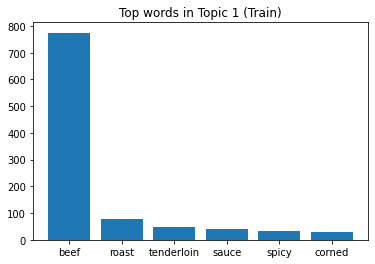

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.bar(freq_tp1.index[:6],freq_tp1.values[:6])
plt.title("Top words in Topic 1 (Train)")

Text(0.5, 1.0, 'Top words in Topic 1 (Test)')

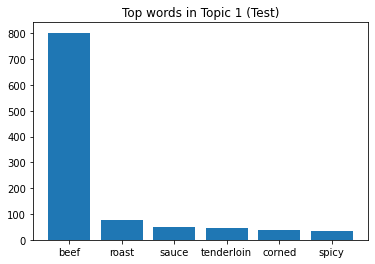

In [ ]:
plt.bar(freq_tp1_test.index[:6],freq_tp1_test.values[:6])
plt.title("Top words in Topic 1 (Test)")

In [ ]:
# topic = 50
check_50 = df_w2v[df_w2v["topic_cluster"] == 50]
check_50test = df_w2v_test[df_w2v_test["topic_cluster"] == 50]

#word frequency quick check
check_50["title"] = check_50["title"].apply(lambda x: " ".join(x))
freq_tp50 = check_50["title"].str.split(expand=True).stack().value_counts()

check_50test["title"] = check_50test["title"].apply(lambda x: " ".join(x))
freq_tp50_test = check_50test["title"].str.split(expand=True).stack().value_counts()

Text(0.5, 1.0, 'Top words in Topic 50 (Train)')

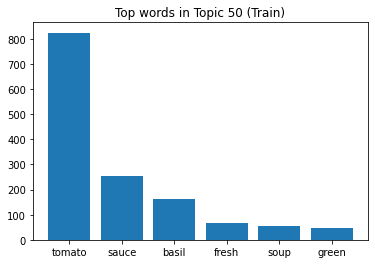

In [ ]:
plt.bar(freq_tp50.index[:6],freq_tp50.values[:6])
plt.title("Top words in Topic 50 (Train)")

Text(0.5, 1.0, 'Top words in Topic 50 (Test)')

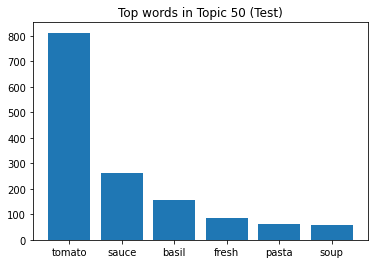

In [ ]:
plt.bar(freq_tp50_test.index[:6],freq_tp50_test.values[:6])
plt.title("Top words in Topic 50 (Test)")